In [1]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.datasets import make_moons, make_blobs

In [2]:
from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

rng = np.random.RandomState(42)
num_ensemblers = 100
classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH()))]

In [3]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
]

In [4]:
# Show the statics of the data
print("Number of inliers: %i" % n_inliers)
print("Number of outliers: %i" % n_outliers)
print(
    "Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n".format(
        shape=ground_truth.shape
    )
)
print(ground_truth)

Number of inliers: 255
Number of outliers: 45
Ground truth shape is (300,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


  0%|          | 0/4 [00:00<?, ?it/s]

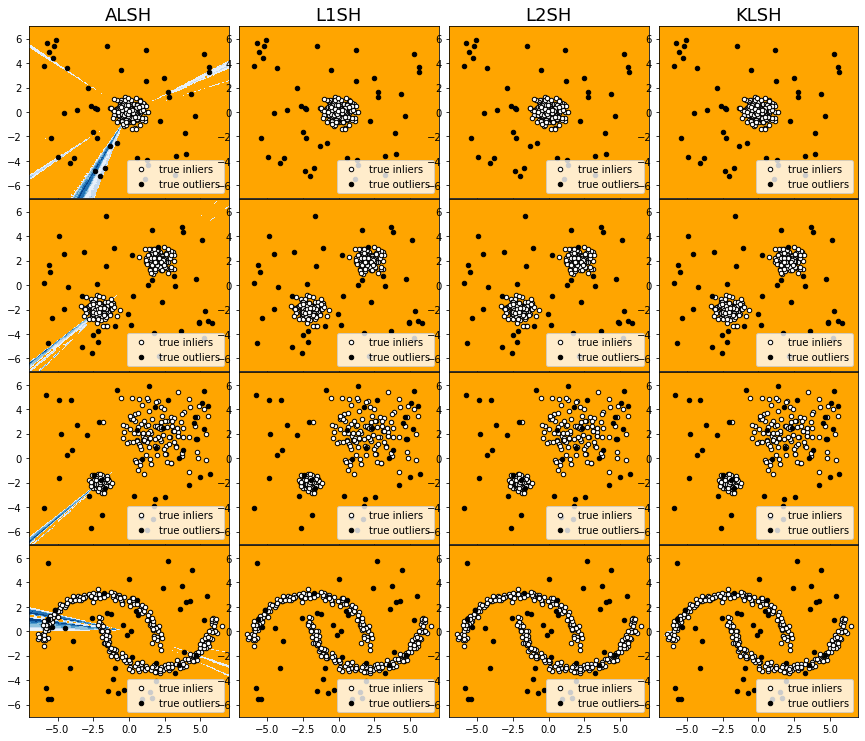

In [5]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers) * 2 + 4, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(tqdm(datasets)):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for i_alg, (alg_name, algorithm) in enumerate(classifiers):
        algorithm.fit(X)
        scores_pred = algorithm.decision_function(X) * -1

        # y_pred = algorithm.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        # plot the levels lines and the points
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)

        subplot = plt.subplot(len(datasets), len(classifiers), plot_num)
        if i_dataset == 0:
            plt.title(alg_name, size=18)
        subplot.contourf(
            xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(
            X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
        )
        c = subplot.scatter(
            X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
        )
        subplot.axis("tight")
        subplot.legend(
            [b, c],
            ["true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc="lower right",
        )
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))

        plot_num += 1

plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

0 ALSH: 0.46653594771241824
0 L1SH: 0.9994771241830066
0 L2SH: 1.0
0 KLSH: 0.9731590413943355
1 ALSH: 0.9313725490196078
1 L1SH: 0.9969498910675382
1 L2SH: 0.9988671023965141
1 KLSH: 0.961917211328976
2 ALSH: 0.8408714596949891
2 L1SH: 0.8993464052287582
2 L2SH: 0.901437908496732
2 KLSH: 0.8109803921568628


ValueError: Found input variables with inconsistent numbers of samples: [300, 345]

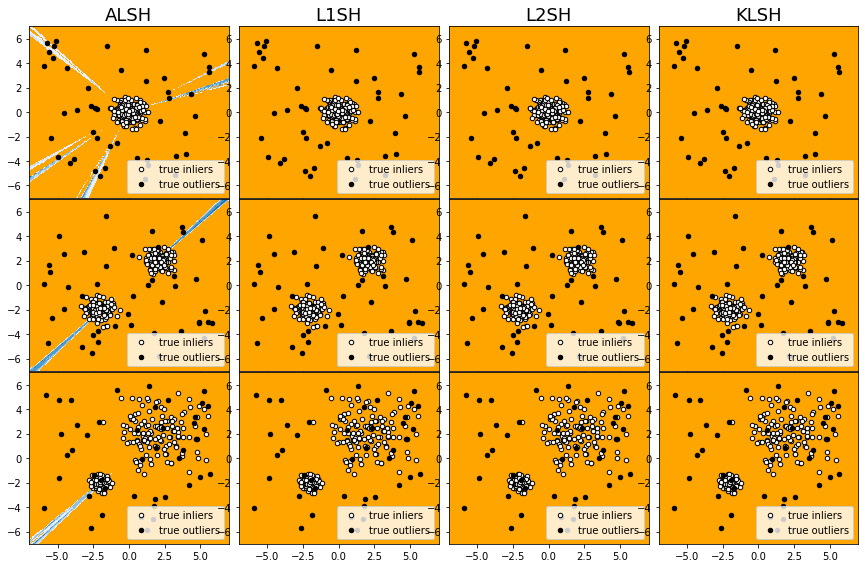

In [8]:
from sklearn.metrics import roc_auc_score

xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers) * 2 + 4, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(tqdm(datasets)):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for i_alg, (alg_name, algorithm) in enumerate(classifiers):
        algorithm.fit(X)
        scores_pred = algorithm.decision_function(X) * -1
        
        #AUC
        y_pred = scores_pred.ravel()
        auc = roc_auc_score(ground_truth, y_pred)
        print(i_dataset, alg_name + ":", auc)
        


        # y_pred = algorithm.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        # plot the levels lines and the points
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)

        subplot = plt.subplot(len(datasets), len(classifiers), plot_num)
        if i_dataset == 0:
            plt.title(alg_name, size=18)
        subplot.contourf(
            xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(
            X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
        )
        c = subplot.scatter(
            X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
        )
        subplot.axis("tight")
        subplot.legend(
            [b, c],
            ["true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc="lower right",
        )
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))

        plot_num += 1

plt.show()

sklearn.ISO_AUC: 0.7801867911941294
sklearn.ISO_PR: 0.19466186938843685
ALSH_AUC: 0.5884339559706471
ALSH_PR: 0.13166727780081808
L1SH_AUC: 0.9984156104069379
L1SH_PR: 0.8571428571428572
L2SH_AUC: 0.9387925283522349
L2SH_PR: 0.5319338158460876
KLSH_AUC: 0.9997498332221482
KLSH_PR: 0.9659090909090909
OPTiF_AUC: 0.9295363575717145
OPTiF_PR: 0.5002839492108881


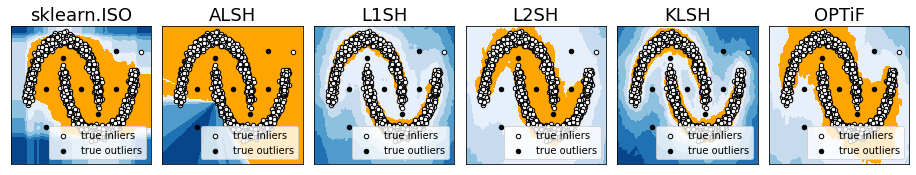

In [27]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=100)),
               ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
               ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]


xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(classifiers)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i_alg, (alg_name, algorithm) in enumerate(classifiers):
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 32
iForest_AUC: 0.5658772515010007
iForest_PR: 0.13391159945720624
Sampling size= 64
iForest_AUC: 0.6535190126751167
iForest_PR: 0.1875610410117992
Sampling size= 128
iForest_AUC: 0.6652768512341561
iForest_PR: 0.08840583645749378
Sampling size= 256
iForest_AUC: 0.8195463642428286
iForest_PR: 0.25117265259191873
Sampling size= 512
iForest_AUC: 0.9546364242828551
iForest_PR: 0.42225594527423793
Sampling size= 1024
iForest_AUC: 0.9779019346230821
iForest_PR: 0.46366117943689844


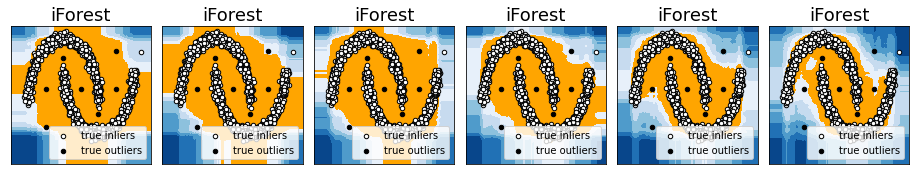

In [9]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

# classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=num_ensemblers)),
#                ("EIF", eif.iForest(X, ntrees=num_ensemblers, sample_size=256, ExtensionLevel=1)),
#                ("iNNE", INNE(contamination=outliers_fraction, max_samples=16, random_state=rng)),
#                ("IDKD", IDKD(contamination=outliers_fraction, max_samples=16, random_state=random_state)),
#                ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
#                ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
#                ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
#                ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
#                ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "iForest"
algorithm = IsolationForest(random_state=rng, n_estimators=100)



xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


# for i_alg, (alg_name, algorithm) in enumerate(classifiers):
for i in sample_sizes2:
    print("Sampling size=",i)
    algorithm = IsolationForest(random_state=rng, n_estimators=num_ensemblers, max_samples=i)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

# anomaly score of EIF
#     scores_pred = algorithm.compute_paths(X_in=X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

# anomaly score of EIF
#     Z = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 2
iNNE_AUC: 0.572506671114076
iNNE_PR: 0.13120258222819112
Sampling size= 4
iNNE_AUC: 0.678285523682455
iNNE_PR: 0.27765867290439766
Sampling size= 8
iNNE_AUC: 0.9234489659773182
iNNE_PR: 0.4417981542511296
Sampling size= 16
iNNE_AUC: 0.9982488325550367
iNNE_PR: 0.8950892857142857
Sampling size= 32
iNNE_AUC: 1.0
iNNE_PR: 1.0
Sampling size= 64
iNNE_AUC: 1.0
iNNE_PR: 1.0


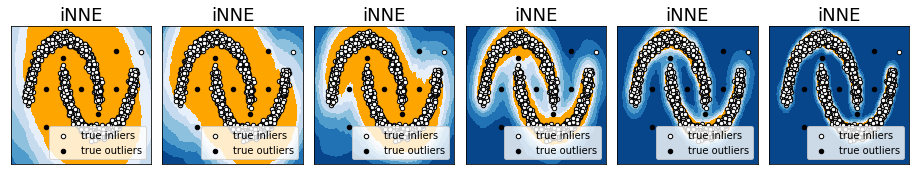

In [14]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample


sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "iNNE"
algorithm = INNE(contamination=outliers_fraction, max_samples=16, random_state=rng)



xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = INNE(contamination=outliers_fraction, max_samples=i, random_state=rng)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)*(-1.0)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0*y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0*y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])*(-1.0)
    
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 2
IDKD_AUC: 0.6221647765176784
IDKD_PR: 0.009090085886102077
Sampling size= 4
IDKD_AUC: 0.6480987324883256
IDKD_PR: 0.14111134217792856
Sampling size= 8
IDKD_AUC: 0.784731487658439
IDKD_PR: 0.3965323261200067
Sampling size= 16
IDKD_AUC: 0.9781521014009339
IDKD_PR: 0.4924992288433549
Sampling size= 32
IDKD_AUC: 0.9294946631087393
IDKD_PR: 0.6796992160872529
Sampling size= 64
IDKD_AUC: 0.9996664442961976
IDKD_PR: 0.9583333333333333


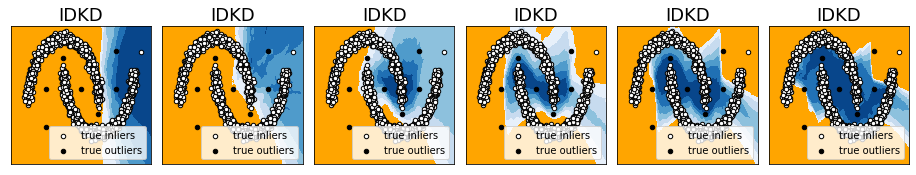

In [15]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample


sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "IDKD"
algorithm = IDKD(contamination=outliers_fraction, max_samples=16, random_state=rng)



xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = IDKD(contamination=outliers_fraction, max_samples=i, random_state=rng)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)*(-1.0)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0*y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0*y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])*(-1.0)
    
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

ALSH_AUC: 0.5391927951967979
ALSH_PR: 0.13034550317653382
L1SH_AUC: 0.9984989993328885
L1SH_PR: 0.8593073593073592
L2SH_AUC: 0.9529686457638425
L2SH_PR: 0.510399699609979
KLSH_AUC: 0.999332888592395
KLSH_PR: 0.9375
OPTiF_AUC: 0.8944296197464976
OPTiF_PR: 0.5546164679005015


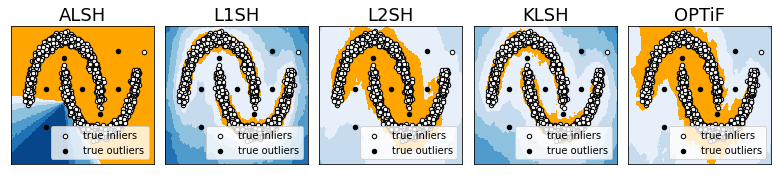

In [16]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
               ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
# sample_sizes = [2,4,8,16,32,64]
# sample_sizes2 = [32,64,128,256,512,1024]


xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(classifiers)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i_alg, (alg_name, algorithm) in enumerate(classifiers):
# for i in sample_sizes2:
#     print("Sampling size=",i)
#     algorithm = IsolationForest(random_state=rng, n_estimators=num_ensemblers, max_samples=i)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 55
OPTiF_AUC: 0.9528852568378919
OPTiF_PR: 0.43803965053603194
Sampling size= 148
OPTiF_AUC: 0.9044362908605738
OPTiF_PR: 0.4180042641903684
Sampling size= 403
OPTiF_AUC: 0.9889926617745163
OPTiF_PR: 0.6743297687514977
Sampling size= 500
OPTiF_AUC: 0.858155436957972
OPTiF_PR: 0.4713319882336448


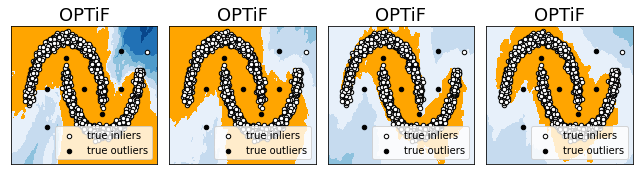

In [17]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

# classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
#                ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
#                ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
#                ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
#                ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
# sample_sizes = [2,4,8,16,32,64]
# sample_sizes2 = [32,64,128,256,512,1024]

sample_sizes = [55,148,403,500]
alg_name="OPTiF"
algorithm=OptIForest('L2OPT', num_ensemblers, threshold, branch)

xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


# for i_alg, (alg_name, algorithm) in enumerate(classifiers):
for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = OptIForest('L2OPT', num_ensemblers, i, branch)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 32
iForest_AUC: 0.8785185185185186
iForest_PR: 0.4964437987036857
Sampling size= 64
iForest_AUC: 0.9444444444444445
iForest_PR: 0.6952870472607315
Sampling size= 128
iForest_AUC: 0.9629629629629629
iForest_PR: 0.6990177133655395
Sampling size= 256
iForest_AUC: 0.9814814814814814
iForest_PR: 0.8026455026455028
Sampling size= 512
iForest_AUC: 0.9851851851851852
iForest_PR: 0.8242895448777803
Sampling size= 1024
iForest_AUC: 0.9814814814814815
iForest_PR: 0.7945785151667506


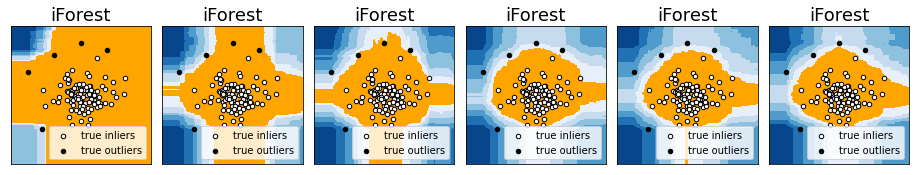

In [16]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/hard.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 9
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

# classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=num_ensemblers)),
#                ("EIF", eif.iForest(X, ntrees=num_ensemblers, sample_size=256, ExtensionLevel=1)),
#                ("iNNE", INNE(contamination=outliers_fraction, max_samples=16, random_state=rng)),
#                ("IDKD", IDKD(contamination=outliers_fraction, max_samples=16, random_state=random_state)),
#                ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
#                ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
#                ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
#                ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
#                ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "iForest"
algorithm = IsolationForest(random_state=rng, n_estimators=100)



xx, yy = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-6, 6, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


# for i_alg, (alg_name, algorithm) in enumerate(classifiers):
for i in sample_sizes2:
    print("Sampling size=",i)
    algorithm = IsolationForest(random_state=rng, n_estimators=num_ensemblers, max_samples=i)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

# anomaly score of EIF
#     scores_pred = algorithm.compute_paths(X_in=X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 15)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

# anomaly score of EIF
#     Z = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-4.5, 4.5))
    subplot.set_ylim((-6, 6))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 2
iNNE_AUC: 0.9088888888888889
iNNE_PR: 0.5826846121098994
Sampling size= 4
iNNE_AUC: 1.0
iNNE_PR: 1.0
Sampling size= 8
iNNE_AUC: 0.9903703703703703
iNNE_PR: 0.8727833894500563
Sampling size= 16
iNNE_AUC: 0.9925925925925927
iNNE_PR: 0.9040835707502375
Sampling size= 32
iNNE_AUC: 0.9940740740740741
iNNE_PR: 0.9182098765432101
Sampling size= 64
iNNE_AUC: 0.9637037037037037
iNNE_PR: 0.8142135642135642


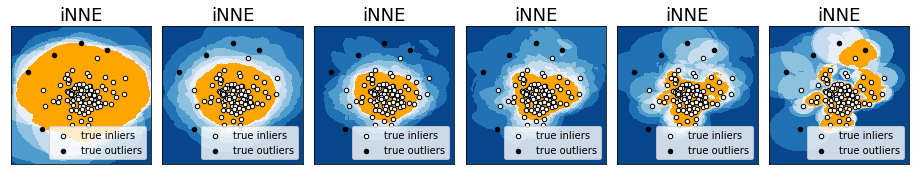

In [19]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/hard.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 9
n_sample = len(X)
outliers_fraction = n_outliers/n_sample


sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "iNNE"
algorithm = INNE(contamination=outliers_fraction, max_samples=16, random_state=rng)



xx, yy = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-6, 6, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = INNE(contamination=outliers_fraction, max_samples=i, random_state=rng)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)*(-1.0)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0*y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0*y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 15)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])*(-1.0)
    
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-4.5, 4.5))
    subplot.set_ylim((-6, 6))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 2
IDKD_AUC: 0.6496296296296296
IDKD_PR: 0.22408609707295882
Sampling size= 4
IDKD_AUC: 0.7948148148148149
IDKD_PR: 0.42444289438032334
Sampling size= 8
IDKD_AUC: 0.9496296296296296
IDKD_PR: 0.5855412689044402
Sampling size= 16
IDKD_AUC: 0.9525925925925927
IDKD_PR: 0.6633473486921764
Sampling size= 32
IDKD_AUC: 0.9685185185185186
IDKD_PR: 0.7486601809182456
Sampling size= 64
IDKD_AUC: 0.9866666666666667
IDKD_PR: 0.8025030525030525


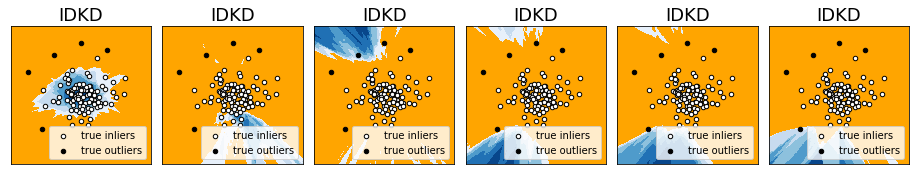

In [45]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/hard.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 9
n_sample = len(X)
outliers_fraction = n_outliers/n_sample


sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "IDKD"
algorithm = IDKD(contamination=outliers_fraction, max_samples=16, random_state=rng)



xx, yy = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-6, 6, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = IDKD(contamination=outliers_fraction, max_samples=i, random_state=rng)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, y_pred)
    pr_auc = average_precision_score(ground_truth, y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 20)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    
    threshold = percentile(Z, 15)
    
    Z = Z.reshape(xx.shape)
    
#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-4.5, 4.5))
    subplot.set_ylim((-6, 6))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

ALSH_AUC: 0.5562962962962963
ALSH_PR: 0.08367884819483062
L1SH_AUC: 0.9496296296296296
L1SH_PR: 0.6458653846153846
L2SH_AUC: 0.9518518518518518
L2SH_PR: 0.6533454849244322
KLSH_AUC: 0.6562962962962963
KLSH_PR: 0.43254840767645253


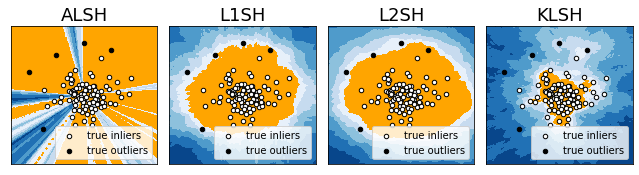

In [17]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/hard.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 9
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH()))]
# sample_sizes = [2,4,8,16,32,64]
# sample_sizes2 = [32,64,128,256,512,1024]


xx, yy = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-6, 6, 150))
plt.figure(figsize=(len(classifiers)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i_alg, (alg_name, algorithm) in enumerate(classifiers):
# for i in sample_sizes2:
#     print("Sampling size=",i)
#     algorithm = IsolationForest(random_state=rng, n_estimators=num_ensemblers, max_samples=i)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 15)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-4.5, 4.5))
    subplot.set_ylim((-6, 6))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

Sampling size= 55
OPTiF_AUC: 0.9214814814814816
OPTiF_PR: 0.583266744524351
Sampling size= 148
OPTiF_AUC: 0.9437037037037036
OPTiF_PR: 0.6220016542597189
Sampling size= 403
OPTiF_AUC: 0.9585185185185185
OPTiF_PR: 0.6813291646624979
Sampling size= 500
OPTiF_AUC: 0.9562962962962963
OPTiF_PR: 0.6789993775287892


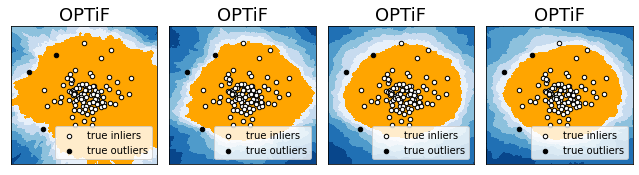

In [18]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

# from src.eif.eif import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/hard.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

# classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
#                ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
#                ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
#                ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
#                ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
# sample_sizes = [2,4,8,16,32,64]
# sample_sizes2 = [32,64,128,256,512,1024]

sample_sizes = [55,148,403,500]
alg_name="OPTiF"
algorithm=OptIForest('L2OPT', num_ensemblers, threshold, branch)

xx, yy = np.meshgrid(np.linspace(-5, 5, 150), np.linspace(-6, 6, 150))
plt.figure(figsize=(len(sample_sizes)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


# for i_alg, (alg_name, algorithm) in enumerate(classifiers):
for i in sample_sizes:
    print("Sampling size=",i)
    algorithm = OptIForest('L2OPT', num_ensemblers, i, branch)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 15)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(sample_sizes), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-4.5, 4.5))
    subplot.set_ylim((-6, 6))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()